# XGBoost: Examples for Regression and Classification.

## Imports & Usefull material

We will the use of XGBoost and its integration with Scikit-Learn.

Some useful links:


*   [XGBoost documentation](https://xgboost.readthedocs.io/en/latest/index.html)
*   [Parameters](https://xgboost.readthedocs.io/en/latest/parameter.html)
*   [Python package](https://xgboost.readthedocs.io/en/latest/python/python_intro.html)




Objective is to demonstrate:


*   regression ✓
*   binary classification ✓
*   multiclass classification ✓
*   cross-validation ✓
*   hyperparameter searching ✓
*   feature importance ✓
*   early stopping ✓
*   evaluations
*   plotting ✓



Let us start with some imports:

In [71]:
import numpy as np

from scipy.stats import uniform, randint

from sklearn.datasets import load_breast_cancer, load_diabetes, load_wine
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler

import xgboost as xgb

And define a couple of functions:

In [72]:
def display_scores(scores):
    print(f'Scores: {scores}\nMean: {np.mean(scores):.3f}\nStd: {np.std(scores):.3f}')

In [73]:
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print(f"Model with rank: {i}")
            print(f"Mean validation score: {results['mean_test_score'][candidate]:.3f} (std: {results['std_test_score'][candidate]:.3f})")
            print(f"Parameters: {results['params'][candidate]}")
            print("")

# Regression

[Diabetes Dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html)

In [74]:
diabetes = load_diabetes()

X = diabetes.data
y = diabetes.target

print(X.shape)
print(y.shape)
print(X[:3,:])

(442, 10)
(442,)
[[ 0.03807591  0.05068012  0.06169621  0.02187239 -0.0442235  -0.03482076
  -0.04340085 -0.00259226  0.01990749 -0.01764613]
 [-0.00188202 -0.04464164 -0.05147406 -0.02632753 -0.00844872 -0.01916334
   0.07441156 -0.03949338 -0.06833155 -0.09220405]
 [ 0.08529891  0.05068012  0.04445121 -0.00567042 -0.04559945 -0.03419447
  -0.03235593 -0.00259226  0.00286131 -0.02593034]]


In [75]:
print("mean: ", np.mean(X, axis=0))
print("max: ", np.max(X, axis=0))
print("min: ", np.min(X, axis=0))

mean:  [-1.44429466e-18  2.54321451e-18 -2.25592546e-16 -4.85408596e-17
 -1.42859580e-17  3.89881064e-17 -6.02836031e-18 -1.78809958e-17
  9.24348582e-17  1.35176953e-17]
max:  [0.11072668 0.05068012 0.17055523 0.13204362 0.15391371 0.19878799
 0.18117906 0.18523444 0.13359728 0.13561183]
min:  [-0.10722563 -0.04464164 -0.0902753  -0.1123988  -0.12678067 -0.11561307
 -0.10230705 -0.0763945  -0.12609712 -0.13776723]


In [76]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

xgb_model.fit(X, y)

y_pred = xgb_model.predict(X)

mse=mean_squared_error(y, y_pred)

print(np.sqrt(mse))

0.39512221537109155


And the final model is:

In [77]:
xgb_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

# Binary classification

[Breast Cancer Dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html)

In [78]:
cancer = load_breast_cancer()

X = cancer.data
y = cancer.target

In [79]:
print(X.shape)
print(y.shape)
print(X[:3,:])

(569, 30)
(569,)
[[1.799e+01 1.038e+01 1.228e+02 1.001e+03 1.184e-01 2.776e-01 3.001e-01
  1.471e-01 2.419e-01 7.871e-02 1.095e+00 9.053e-01 8.589e+00 1.534e+02
  6.399e-03 4.904e-02 5.373e-02 1.587e-02 3.003e-02 6.193e-03 2.538e+01
  1.733e+01 1.846e+02 2.019e+03 1.622e-01 6.656e-01 7.119e-01 2.654e-01
  4.601e-01 1.189e-01]
 [2.057e+01 1.777e+01 1.329e+02 1.326e+03 8.474e-02 7.864e-02 8.690e-02
  7.017e-02 1.812e-01 5.667e-02 5.435e-01 7.339e-01 3.398e+00 7.408e+01
  5.225e-03 1.308e-02 1.860e-02 1.340e-02 1.389e-02 3.532e-03 2.499e+01
  2.341e+01 1.588e+02 1.956e+03 1.238e-01 1.866e-01 2.416e-01 1.860e-01
  2.750e-01 8.902e-02]
 [1.969e+01 2.125e+01 1.300e+02 1.203e+03 1.096e-01 1.599e-01 1.974e-01
  1.279e-01 2.069e-01 5.999e-02 7.456e-01 7.869e-01 4.585e+00 9.403e+01
  6.150e-03 4.006e-02 3.832e-02 2.058e-02 2.250e-02 4.571e-03 2.357e+01
  2.553e+01 1.525e+02 1.709e+03 1.444e-01 4.245e-01 4.504e-01 2.430e-01
  3.613e-01 8.758e-02]]


In [80]:
print("mean: ", np.mean(X, axis=0))
print("max: ", np.max(X, axis=0))
print("min: ", np.min(X, axis=0))

mean:  [1.41272917e+01 1.92896485e+01 9.19690334e+01 6.54889104e+02
 9.63602812e-02 1.04340984e-01 8.87993158e-02 4.89191459e-02
 1.81161863e-01 6.27976098e-02 4.05172056e-01 1.21685343e+00
 2.86605923e+00 4.03370791e+01 7.04097891e-03 2.54781388e-02
 3.18937163e-02 1.17961371e-02 2.05422988e-02 3.79490387e-03
 1.62691898e+01 2.56772232e+01 1.07261213e+02 8.80583128e+02
 1.32368594e-01 2.54265044e-01 2.72188483e-01 1.14606223e-01
 2.90075571e-01 8.39458172e-02]
max:  [2.811e+01 3.928e+01 1.885e+02 2.501e+03 1.634e-01 3.454e-01 4.268e-01
 2.012e-01 3.040e-01 9.744e-02 2.873e+00 4.885e+00 2.198e+01 5.422e+02
 3.113e-02 1.354e-01 3.960e-01 5.279e-02 7.895e-02 2.984e-02 3.604e+01
 4.954e+01 2.512e+02 4.254e+03 2.226e-01 1.058e+00 1.252e+00 2.910e-01
 6.638e-01 2.075e-01]
min:  [6.981e+00 9.710e+00 4.379e+01 1.435e+02 5.263e-02 1.938e-02 0.000e+00
 0.000e+00 1.060e-01 4.996e-02 1.115e-01 3.602e-01 7.570e-01 6.802e+00
 1.713e-03 2.252e-03 0.000e+00 0.000e+00 7.882e-03 8.948e-04 7.930e+00
 1.

In [81]:
scaler = StandardScaler()
X = scaler.fit_transform(X) # Or first scaler=fit(X) -> then X = scaler.transform(X)

In [82]:
print("mean: ", np.mean(X, axis=0))
print("max: ", np.max(X, axis=0))
print("min: ", np.min(X, axis=0))

mean:  [-3.16286735e-15 -6.53060890e-15 -7.07889127e-16 -8.79983452e-16
  6.13217737e-15 -1.12036918e-15 -4.42138027e-16  9.73249991e-16
 -1.97167024e-15 -1.45363120e-15 -9.07641468e-16 -8.85349205e-16
  1.77367396e-15 -8.29155139e-16 -7.54180940e-16 -3.92187747e-16
  7.91789988e-16 -2.73946068e-16 -3.10823423e-16 -3.36676596e-16
 -2.33322442e-15  1.76367415e-15 -1.19802625e-15  5.04966114e-16
 -5.21317026e-15 -2.17478837e-15  6.85645643e-16 -1.41265636e-16
 -2.28956670e-15  2.57517109e-15]
max:  [ 3.97128765  4.65188898  3.97612984  5.25052883  4.77091122  4.56842498
  4.24358882  3.92792966  4.48475086  4.91091929  8.90690934  6.65527935
  9.46198577 11.04184226  8.02999927  6.14348219 12.0726804   6.64960079
  7.07191706  9.85159257  4.09418939  3.88590505  4.28733746  5.9301724
  3.95537411  5.11287727  4.7006688   2.68587702  6.04604135  6.84685604]
min:  [-2.0296483  -2.22924851 -1.98450403 -1.45444309 -3.11208479 -1.61013634
 -1.11487284 -1.26181958 -2.74411707 -1.81986478 -1.05

In [83]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(X, y)

y_pred = xgb_model.predict(X)

print(confusion_matrix(y, y_pred))

[[212   0]
 [  0 357]]


# Multiclass classification & Standard Scaler

In here you can find information about the [Wine Dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html) and the meaning of its features.

In [84]:
wine = load_wine()

X = wine.data
y = wine.target

In [85]:
print(np.unique(y))

[0 1 2]


In [86]:
print(X.shape)

(178, 13)


We have 569 samples of 30 features each (all numerical).

In [87]:
scaler2 = StandardScaler()
X = scaler2.fit_transform(X) # Or first scaler=fit(X) -> then X = scaler.transform(X)

In [88]:
xgb_model = xgb.XGBClassifier(objective="multi:softprob", random_state=42)
xgb_model.fit(X, y)

y_pred = xgb_model.predict(X)

print(confusion_matrix(y, y_pred))

[[59  0  0]
 [ 0 71  0]
 [ 0  0 48]]


# Cross-validation

In [89]:
diabetes = load_diabetes()

X = diabetes.data
y = diabetes.target

kfold = KFold(n_splits=10, shuffle=True, random_state=42)

scores = []

for train_index, test_index in kfold.split(X):

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    xgb_model = xgb.XGBRegressor(objective="reg:squarederror")
    xgb_model.fit(X_train, y_train)

    y_pred = xgb_model.predict(X_test)

    scores.append(mean_squared_error(y_test, y_pred))

display_scores(np.sqrt(scores))

Scores: [59.03965501 65.59331953 51.57350598 72.32064012 73.28533005 64.45705469
 60.15234542 71.73034452 58.51737867 66.81255974]
Mean: 64.348
Std: 6.697


Or equivalently:

In [90]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

scores = cross_val_score(xgb_model, X, y, scoring="neg_mean_squared_error", cv=10)

display_scores(np.sqrt(-scores))

Scores: [59.74646987 57.44576747 65.09830991 63.39192845 67.59274825 68.67236268
 63.59599688 61.69022646 75.75210193 63.65663249]
Mean: 64.664
Std: 4.865


# Hyperparameter search

In [91]:
diabetes = load_diabetes()

X = diabetes.data
y = diabetes.target

xgb_model = xgb.XGBRegressor(objective="reg:squarederror")

params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3),
    "max_depth": randint(2, 6),
    "n_estimators": randint(100, 150),
    "subsample": uniform(0.6, 0.4)
}

search = RandomizedSearchCV(xgb_model, param_distributions=params, random_state=42, n_iter=200, cv=3, verbose=1, n_jobs=1, return_train_score=True)

search.fit(X, y)

report_best_scores(search.cv_results_, 1)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
Model with rank: 1
Mean validation score: 0.469 (std: 0.014)
Parameters: {'colsample_bytree': 0.7902634929450308, 'gamma': 0.1424202471887338, 'learning_rate': 0.041066084206359835, 'max_depth': 2, 'n_estimators': 101, 'subsample': 0.8010716092915446}



# Early stopping:

In [92]:
cancer = load_breast_cancer()

X = cancer.data
y = cancer.target

xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, eval_metric='auc', early_stopping_rounds=3)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)])

y_pred = xgb_model.predict(X_test)

accuracy_score(y_test, y_pred)

[0]	validation_0-auc:0.96286
[1]	validation_0-auc:0.97742
[2]	validation_0-auc:0.97514
[3]	validation_0-auc:0.98096
[4]	validation_0-auc:0.98637
[5]	validation_0-auc:0.99043
[6]	validation_0-auc:0.98918
[7]	validation_0-auc:0.98980
[8]	validation_0-auc:0.98939


0.965034965034965

In [93]:
print(f"best score: {xgb_model.best_score}, best iteration: {xgb_model.best_iteration}")

best score: 0.9904286308780691, best iteration: 5


# Evaluation

In [94]:
cancer = load_breast_cancer()

X = cancer.data
y = cancer.target

xgb_model = xgb.XGBClassifier(objective="binary:logistic", n_estimators=20, random_state=42, eval_metric=["auc", "error"])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)])

[0]	validation_0-auc:0.96286	validation_0-error:0.06993
[1]	validation_0-auc:0.97742	validation_0-error:0.03497
[2]	validation_0-auc:0.97514	validation_0-error:0.04196
[3]	validation_0-auc:0.98096	validation_0-error:0.03497
[4]	validation_0-auc:0.98637	validation_0-error:0.03497
[5]	validation_0-auc:0.99043	validation_0-error:0.03497
[6]	validation_0-auc:0.98918	validation_0-error:0.03497


[7]	validation_0-auc:0.98980	validation_0-error:0.03497
[8]	validation_0-auc:0.98939	validation_0-error:0.03497
[9]	validation_0-auc:0.99251	validation_0-error:0.03497
[10]	validation_0-auc:0.99209	validation_0-error:0.03497
[11]	validation_0-auc:0.99168	validation_0-error:0.03497
[12]	validation_0-auc:0.99313	validation_0-error:0.03497
[13]	validation_0-auc:0.99313	validation_0-error:0.03497
[14]	validation_0-auc:0.99355	validation_0-error:0.03497
[15]	validation_0-auc:0.99313	validation_0-error:0.03497
[16]	validation_0-auc:0.99272	validation_0-error:0.03497
[17]	validation_0-auc:0.99272	validation_0-error:0.03497
[18]	validation_0-auc:0.99293	validation_0-error:0.03497
[19]	validation_0-auc:0.99293	validation_0-error:0.03497


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=['auc', 'error'],
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=20,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [95]:
y_pred = xgb_model.predict(X_test)
print('error : ', 1-accuracy_score(y_test, y_pred))

error :  0.034965034965035


# Bonus: Plotting and feature importance

/Users/imanolgranada/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


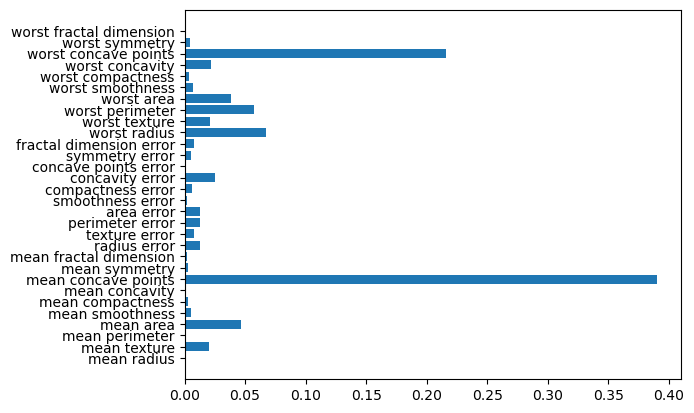

In [101]:
cancer = load_breast_cancer()
X = cancer.data
y = cancer.target
feature_names = cancer.feature_names

xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, eval_metric="auc")

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

xgb_model.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_test, y_test)], verbose=False)

importance = xgb_model.feature_importances_

fig, ax = plt.subplots()
ylocs = np.arange(len(importance))
ax.barh(ylocs, importance, align="center")
ax.set_yticks(ylocs)
ax.set_yticklabels(feature_names)

plt.show()